# Assignment 2
In this assignment, I am predicting the price of small to mid-size apartments hosting 2-6 guests so that a fictional company can price their new apartments before putting them on the market.
I start off with the exploratory data analysis and data work, then move on to creating my models and analyzing their effectiveness using RMSE. I then use the best model to predict apartment prices based on the number of accommodates. 
- Model 1: Linear Regression with OLS
- Model 2: Linear Regression with LASSO
- Model 3: Linear Regression with LASSO using ElasticNet
- Model 4: CART (Regression Tree)
- Model 5: Random Forest

### Importing Beginning Libraries

In [72]:
import pandas as pd
import numpy as np
import math
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
import warnings
warnings.filterwarnings('ignore')

### Reading Data & Exploratory Data Analysis

In [2]:
data = pd.read_csv('austinairbnblistings.csv')

In [3]:
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,2,668,2023-11-20,3.71,1,330,47,NaN
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,NaN,1,294,2023-12-07,1.76,1,0,20,NaN
2,218402,Home in Austin · ★4.74 · 1 bedroom · 1 bed · 1...,1129520,Paulette,NaN,78754,30.36145,-97.64397,Private room,30.0,28,29,2023-09-24,0.20,1,252,2,NaN


In [4]:
data.shape
#15,419 observations

(15419, 18)

In [5]:
data = data.loc[data['room_type'] == 'Entire home/apt']

In [6]:
in_depth_data = pd.read_csv('indepthaustinairbnb.csv')

In [7]:
in_depth_data.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20231215200307,2023-12-16,city scrape,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
1,5769,https://www.airbnb.com/rooms/5769,20231215200307,2023-12-16,previous scrape,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.76,4.92,NaN,f,1,0,1,0,1.76
2,6413,https://www.airbnb.com/rooms/6413,20231215200307,2023-12-16,previous scrape,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.70


In [8]:
in_depth_data = in_depth_data.loc[(in_depth_data['accommodates'] >=2) & (in_depth_data['accommodates'] <=6) ]

In [9]:
in_depth_data.accommodates.value_counts()

accommodates
2    3964
4    3340
6    2293
3    1047
5     837
Name: count, dtype: int64

In [10]:
#created new df airbnb (combines both previous data frames)
airbnb = pd.merge(data, in_depth_data, on = 'id')
#9,348 observations

In [11]:
airbnb.head(3)

,id,name_x,host_id_x,host_name_x,neighbourhood_group,neighbourhood_x,latitude_x,longitude_x,room_type_x,price_x,...,review_scores_communication,review_scores_location,review_scores_value,license_y,instant_bookable,calculated_host_listings_count_y,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month_y
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
1,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,13879,Todd,NaN,78704,30.24885,-97.73587,Entire home/apt,NaN,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.70
2,6448,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,14156,Amy,NaN,78704,30.26034,-97.76487,Entire home/apt,159.0,...,4.97,4.97,4.89,NaN,t,1,1,0,0,2.09


**Plan of Action:**
- outcome variable (y): Price
- predictor variables (x): accommodates, bathrooms, beds, review_scores_rating, property_type, availability_365_x, number_of_reviews, host_is_superhost, minimum_nights_y, maximum_nights
- was going to have interactions (ex. bathrooms*beds, maximum_nights*minimum_nights, availability*number_of_reviews), but plotted using ggplot and the variables didn't seem to have much correlation:

ggplot(airbnb, aes(x = 'availability_365_x', y = 'number_of_reviews_x')) + geom_point()

In [12]:
#change name of column price_x to price
airbnb.rename(columns = {'price_x':'price'}, inplace = True)

In [13]:
#turned bathrooms observations into floats 
airbnb['bathrooms'] = airbnb['bathrooms_text'].apply(lambda x: float(x.split()[0]) if x.split()[0].replace('.', '').isdigit() else None)

In [14]:
#turned observations into booleans (dummy)
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)

In [15]:
#DATA WORK/CLEANING VARIABLES
#must drop any null values in outcome variable (price)
airbnb.price.isnull().sum()
airbnb.dropna(subset = ['price'], inplace = True)

#bathroom observations already turned into floats. now dropping null bathrooms (only 3)
airbnb.bathrooms.isnull().sum()
airbnb.dropna(subset = ['bathrooms'], inplace = True)

#beds. dropping null beds (only 43)
airbnb.beds.isnull().sum()
airbnb.dropna(subset = ['beds'], inplace = True)

#review_scores_rating. over 1000 null values. will impute with median as distribution looks far 
#from normal (used ggplot to plot distribution). will also create flagged variable for missing review_scores_rating
#and flag variable for imputed review_scores_rating
airbnb.review_scores_rating.isnull().sum()
airbnb['missing_review_scores_flag'] = airbnb.review_scores_rating.isnull().astype(int)
airbnb['review_scores_imputed_flag'] = airbnb.review_scores_rating.isnull().astype(int)
airbnb.fillna({'review_scores_rating': airbnb['review_scores_rating'].median()}, inplace=True)

#property type. creating dummy variables (main property types: entire home, entire rental unit, entire condo, 
#entire guesthouse, entire guest suite, entire townhouse, others)
airbnb.property_type.value_counts()
airbnb['entire_home'] = (airbnb['property_type'] == 'Entire home').astype(int)
airbnb['entire_rental_unit'] = (airbnb['property_type'] == 'Entire rental unit').astype(int)
airbnb['entire_condo'] = (airbnb['property_type'] == 'Entire condo').astype(int)
airbnb['entire_guesthouse'] = (airbnb['property_type'] == 'Entire guesthouse').astype(int)
airbnb['entire_guest_suite'] = (airbnb['property_type'] == 'Entire guest suite').astype(int)
airbnb['entire_townhouse'] = (airbnb['property_type'] == 'Entire townhouse').astype(int)
property_types_exclude = ['Entire home', 'Entire rental unit', 'Entire condo', 'Entire guesthouse', 'Entire guest suite', 'Entire townhouse']
airbnb['entire_other_property_type'] = (~airbnb['property_type'].isin(property_types_exclude)).astype(int)

#availability_365_x has no null values and is int. no data work needed
airbnb.availability_365_x.isnull().sum()

#number_of_reviews_x has no null values and is int. no data work needed
airbnb.number_of_reviews_x.isnull().sum()

#host_is_superhost. already dummy variable. no data work needed
airbnb.host_is_superhost

#minimum_nights_y has no null values and is int. no data work needed
airbnb.minimum_nights_y.isnull().sum()

#maximum_nights has no null values and is int. no data work needed
airbnb.maximum_nights.isnull().sum()

#accommodates has no null values and is int. no data work needed
airbnb.accommodates.isnull().sum()

0

## Model 1: Linear Regression with OLS

In [16]:
#list of my predictor variables
selected_features = ['accommodates', 'bathrooms', 'beds', 'review_scores_rating', 'entire_home', 'entire_rental_unit', 'entire_condo',
    'entire_guesthouse' , 'entire_guest_suite' , 'entire_townhouse' , 'availability_365_x' , 'number_of_reviews_x' ,
    'host_is_superhost' , 'minimum_nights_y' , 'maximum_nights']
#entire_other_property_type is the reference category for all the other 'entire' property types listed
#not being a superhost is the refererence category for host_is_superhost

In [17]:
#used structure of code from ch-16 of the Bekes book/Jpynb to create Linear regression model with OLS

#creating training, test (workout) and holdout sets
data_train, data_holdout = train_test_split(airbnb, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

#creating OLS model by fitting model to training set
ols_model = LinearRegression().fit(X,y)

#fitting model to test set (prediction)
y_hat = ols_model.predict(X)

#get the RMSE for the OLS model
ols_rmse = mean_squared_error(y,y_hat,squared=False)
print(f' OLS RMSE: {ols_rmse}')

#see coefficients for each variables
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

ols_model_coeffs_df

 OLS RMSE: 768.7785159567597


,ols_coefficient
Intercept,0.000
accommodates,-45.931
bathrooms,94.481
beds,48.608
review_scores_rating,-72.676
entire_home,-9.758
entire_rental_unit,89.498
entire_condo,-44.905
entire_guesthouse,-40.036
entire_guest_suite,-41.140


## Model 2: Linear regression using LASSO (fitting variables closer to zero)

In [67]:
X = airbnb[selected_features]
y = airbnb['price']

#training/test sets for X variables and y variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#standardizing the features for LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#LASSO regression model
lasso_model = Lasso(alpha=0.1) 

#fitting LASSO model on training set
lasso_model.fit(X_train_scaled, y_train)

#prediction on test set
y_pred = lasso_model.predict(X_test_scaled)

#calculating RMSE
lasso1_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", lasso1_rmse)

#coefficients of model
coefficients = pd.Series(lasso_model.coef_, index=X.columns)
print("LASSO Coefficients:")
print(coefficients)

RMSE: 704.608124452592
LASSO Coefficients:
accommodates           -67.302752
bathrooms               56.805392
beds                    45.906886
review_scores_rating   -23.581954
entire_home             -4.063138
entire_rental_unit      40.761860
entire_condo           -14.659685
entire_guesthouse      -10.196630
entire_guest_suite      -7.080339
entire_townhouse        -7.878811
availability_365_x      71.084536
number_of_reviews_x    -16.766210
host_is_superhost      -40.488057
minimum_nights_y        -2.520527
maximum_nights         -26.324438
dtype: float64


## Model 3: Linear regression using LASSO (ElasticNet)
ElasticNet uses a mix of penalties unlike the previous LASSO model which only used 1 type to enforce shrinkage as close as possible to zero. ElasticNet allows flexibility and can be more robust in case of high correlation between predictor variables.

In [19]:
#creating LASSO model using ElasticNet (using ch. 16 jpynb/Bekes book)
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [20]:
#cross-validation using GridSearchCV
lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [21]:
#again declaring y variable and X as the training set
y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

In [22]:
#fitting training data (25 fits)
%%time
lasso_model_cv.fit(X, y.ravel())

UsageError: Line magic function `%%time` not found.


In [23]:
#have to run it again to get past the error
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................alpha=0.05;, score=-802.843 total time=   0.0s
[CV 2/5] END .....................alpha=0.05;, score=-698.695 total time=   0.0s
[CV 3/5] END .....................alpha=0.05;, score=-826.806 total time=   0.0s
[CV 4/5] END .....................alpha=0.05;, score=-863.211 total time=   0.0s
[CV 5/5] END .....................alpha=0.05;, score=-644.104 total time=   0.0s
[CV 1/5] END ......................alpha=0.1;, score=-802.852 total time=   0.0s
[CV 2/5] END ......................alpha=0.1;, score=-698.668 total time=   0.0s
[CV 3/5] END ......................alpha=0.1;, score=-826.823 total time=   0.0s
[CV 4/5] END ......................alpha=0.1;, score=-863.214 total time=   0.0s
[CV 5/5] END ......................alpha=0.1;, score=-644.100 total time=   0.0s
[CV 1/5] END .....................alpha=0.15;, score=-802.861 total time=   0.0s
[CV 2/5] END .....................alpha=0.15;, sc

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [24]:
ddy, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

In [26]:
#coefficients of best model
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
accommodates,-45.614
bathrooms,93.540
beds,48.240
review_scores_rating,-71.884
entire_home,-4.826
entire_rental_unit,93.478
entire_condo,-39.845
entire_guesthouse,-34.507
entire_guest_suite,-33.941
entire_townhouse,-44.125


In [27]:
lasso_model_cv.best_estimator_
#best model

ElasticNet(alpha=0.1, l1_ratio=1)

In [28]:
#get LASSO (Elastic Net RMSE)
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
print(f' LASSO (ElasticNet) RMSE: {lasso_rmse}')

 LASSO (ElasticNet) RMSE: 767.1312730354497


## Model 4: CART model (Regression Tree)

In [38]:
#again declaring y variable and X as the training set
y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

In [39]:
#creating cart model 
cart_model = DecisionTreeRegressor(random_state=20240131)

In [40]:
#potential ccp alpha parameters
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [41]:
ccp_alphas
ccp_alphas.shape

(4044,)

In [46]:
#trying to select best complexity parameter alpha

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
#create 50 fits
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..ccp_alpha=0.02623461002975197;, score=-659.392 total time=   0.2s
[CV 2/5] END ..ccp_alpha=0.02623461002975197;, score=-561.308 total time=   0.1s
[CV 3/5] END ..ccp_alpha=0.02623461002975197;, score=-420.124 total time=   0.1s
[CV 4/5] END ..ccp_alpha=0.02623461002975197;, score=-616.719 total time=   0.1s
[CV 5/5] END ..ccp_alpha=0.02623461002975197;, score=-454.343 total time=   0.1s
[CV 1/5] END ..ccp_alpha=0.11465698452130674;, score=-659.402 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.11465698452130674;, score=-561.229 total time=   0.1s
[CV 3/5] END ..ccp_alpha=0.11465698452130674;, score=-420.157 total time=   0.1s
[CV 4/5] END ..ccp_alpha=0.11465698452130674;, score=-617.276 total time=   0.1s
[CV 5/5] END ..ccp_alpha=0.11465698452130674;, score=-454.173 total time=   0.1s
[CV 1/5] END ...ccp_alpha=0.8623160710873304;, score=-659.052 total time=   0.1s
[CV 2/5] END ...ccp_alpha=0.8623160710873304;, s

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240131),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 6.93889390e-16, 6.93489825e-06, ...,
       2.10719929e+04, 7.59047277e+04, 1.11798324e+05])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [47]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
print(f'CART RMSE: {cart_rmse}')

CART RMSE: 542.1449962181807


## Model 5: Random Forest Model

In [48]:
#again declaring y variable and X as the training set
y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

In [50]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 4.00.


In [51]:
rfr = RandomForestRegressor(random_state = 20240131)

In [52]:
#setting levels of max features and min. sample leafs to have in terminal nodes
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [53]:
#cross valdiation
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [54]:
%%time
#takes a while (creating 6000 trees!!)
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-406.356 total time=   0.8s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-432.643 total time=   0.8s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-396.694 total time=   0.8s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-511.066 total time=   0.8s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-436.018 total time=   0.8s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-474.174 total time=   0.6s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-447.706 total time=   0.6s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-458.375 total time=   0.6s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-565.177 total time=   0.6s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-462.721 total time=   0.6s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-531.994 total time=   0.6s
[CV 2/5] 

In [55]:
#df to see best models and RMSE
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [56]:
#change names of columns
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [58]:
df_rf_model_cv_results
#would just take the abs value of these RMSE scores

,max features,min node size,RMSE
0,6,5,-436.555236
1,6,10,-481.630601
2,6,15,-532.341879
3,8,5,-438.573836
4,8,10,-484.490831
5,8,15,-522.545605
6,10,5,-438.944305
7,10,10,-487.782154
8,10,15,-525.150115
9,12,5,-446.161897


In [59]:
#df showing max features by min node size
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,436.56,481.63,532.34
8,438.57,484.49,522.55
10,438.94,487.78,525.15
12,446.16,497.49,535.14


In [60]:
#best random forest score
rf_model.best_score_

-436.5552363162077

In [61]:
#best random forest parameters
rf_model.best_params_

{'max_features': 6, 'min_samples_leaf': 5}

In [62]:
#importances of each variables
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
accommodates,0.072609
bathrooms,0.008980
beds,0.007625
review_scores_rating,0.202485
entire_home,0.002232
entire_rental_unit,0.024191
entire_condo,0.000559
entire_guesthouse,0.000024
entire_guest_suite,0.000013


In [64]:
#seeing important and cumulative importance of each predictor variable
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [65]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})
#availability in the next year is the most important predictor variable

,variable,imp,cumulative_imp
0,availability_365_x,31.9%,31.9%
1,review_scores_rating,20.2%,52.1%
2,minimum_nights_y,15.3%,67.4%
3,number_of_reviews_x,14.6%,82.0%
4,accommodates,7.3%,89.3%
5,maximum_nights,5.0%,94.2%
6,entire_rental_unit,2.4%,96.7%
7,host_is_superhost,1.4%,98.1%
8,bathrooms,0.9%,99.0%
9,beds,0.8%,99.7%


## RMSE Comparison of different models

In [68]:
#df to see each model type and its CV RMSE
pd.DataFrame({'Model Type': ['OLS', 'LASSO', 'LASSO (ElasticNet)', 'CART', 'Random Forest'],
              'CV RMSE': [ols_rmse, lasso1_rmse, lasso_rmse, cart_rmse, np.abs(rf_model.best_score_)]}, 
            index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
#Random Forest was best CV RMSE

,Model Type,CV RMSE
Model 1,OLS,768.778516
Model 2,LASSO,704.608124
Model 3,LASSO (ElasticNet),767.131273
Model 4,CART,542.144996
Model 5,Random Forest,436.555236


The final Random Forest model seems to have the best cross-validated RMSE. This means that on average, the random forest model's predictions are off by $436 in comparison to the actual apartment prices in my dataset.

## Partial Dependence Plot using Random Forest Model
Because Model 5, the Random Forest model proved to have the best cross-valdiated RMSE, I am using this model to predict the average cost of apartments by number of accommodates.

In [73]:
###Trying partial dependence plot showing average price per accommodate

preprocessing = ColumnTransformer([
    ("num", "passthrough", selected_features)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)]
)

In [74]:
%%time
rf_pipeline.fit(data_train[selected_features],data_train.price)

CPU times: user 979 ms, sys: 30.9 ms, total: 1.01 s
Wall time: 1.05 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['accommodates', 'bathrooms',
                                                   'beds',
                                                   'review_scores_rating',
                                                   'entire_home',
                                                   'entire_rental_unit',
                                                   'entire_condo',
                                                   'entire_guesthouse',
                                                   'entire_guest_suite',
                                                   'entire_townhouse',
                                                   'availability_365_x',
                                                   'number_of_reviews_x',
                                                   'host_is_superhost',
                                                   'minimum_nights_y',
                                                   'maximum_nights'])])),
                ('regressor',
                 RandomForestRegressor(max_features=6, min_samples_leaf=5,
                                       random_state=20240131))])

In [75]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[selected_features],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 7.05 s, sys: 90.6 ms, total: 7.14 s
Wall time: 7.5 s


In [77]:
#creating df for accommodates and predictions of prices
accommodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[selected_features], ["accommodates"], kind="average"
)

In [78]:
airbnb.groupby('accommodates')['price'].mean()
#the prediction of avg price by number of accommodates is not too far off from the average in the work set

accommodates
2    269.830862
3    127.476266
4    211.619142
5    216.609177
6    263.620929
Name: price, dtype: float64

In [80]:
#comparing actual average price by number of accommodates to Random Forest's prediction of average price per accommodate
pred_avg_price_by_accom = pd.DataFrame({
    'number_of_accommodates': accommodates_pdp['grid_values'][0], 
    'actual_average_price': airbnb.groupby('accommodates')['price'].mean(),
    'predicted_average_price': accommodates_pdp['average'][0],
    })

# Set 'number_of_accommodates' as the index
pred_avg_price_by_accom = pred_avg_price_by_accom.set_index('number_of_accommodates')
pred_avg_price_by_accom

,actual_average_price,predicted_average_price
number_of_accommodates,,
2,269.830862,235.467214
3,127.476266,210.105661
4,211.619142,216.035901
5,216.609177,219.032265
6,263.620929,228.874237


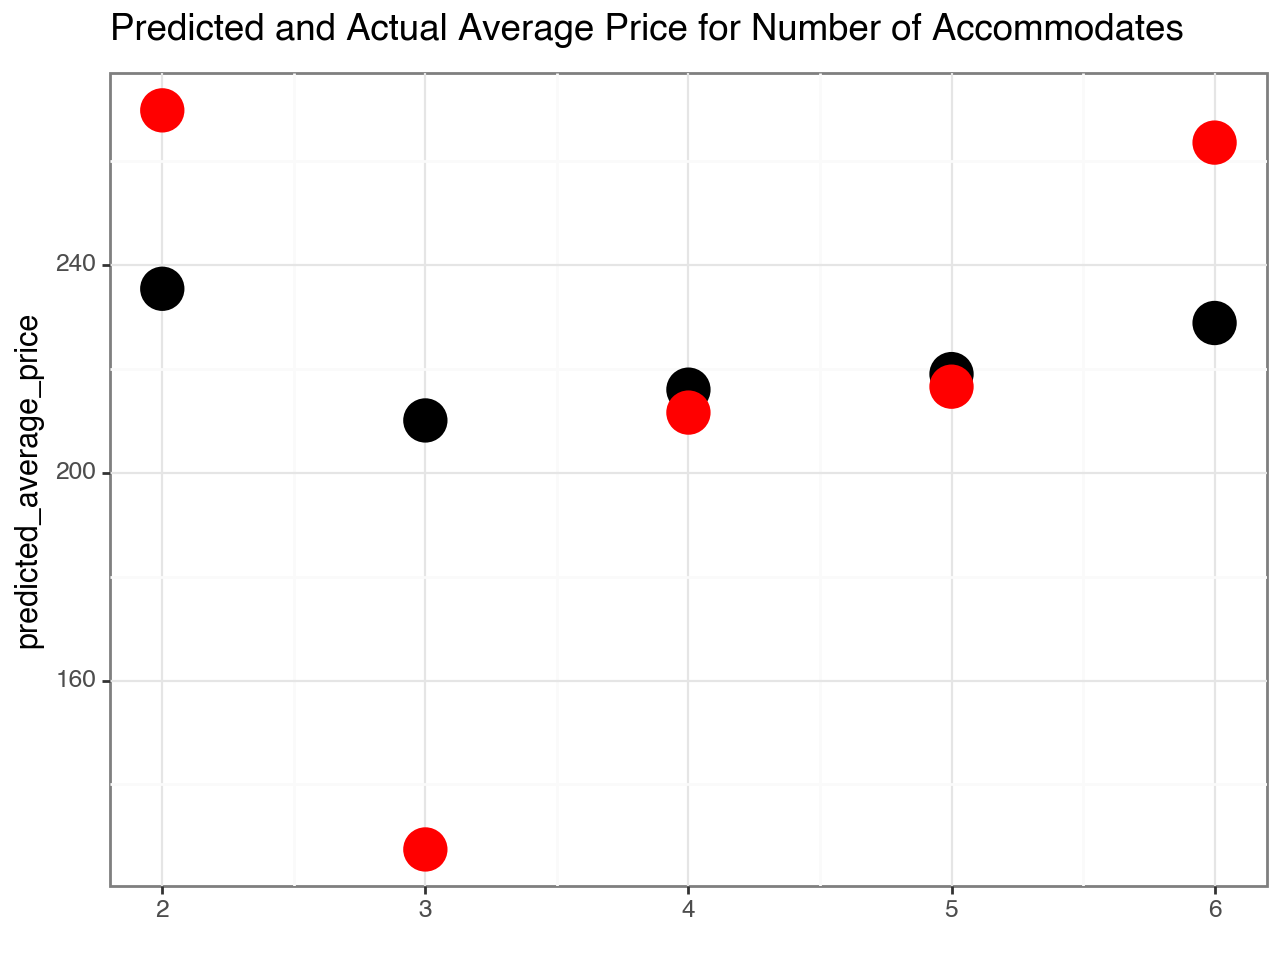

<Figure Size: (640 x 480)>

In [97]:
#partial depenedence plot showing number of accommodates by Random Forest's predicted average_price
#(keeping the other predictor variables constant)
p = (ggplot(pred_avg_price_by_accom, aes(x = range(2,7), y = 'predicted_average_price')) 
 + geom_point(size = 8) + theme_bw() + ggtitle('Predicted and Actual Average Price for Number of Accommodates')
    +geom_point(aes(x = range(2,7), y = 'actual_average_price'), size = 8, color = 'red'))
p

#Random Forest's predicted_average_price = black
#actual_average_price from the dataset = red